# Imports

In [95]:
from Code_Ring_Network import CodeRingNetwork
from utilities import bimodal_exponential_noise, exponential

import numpy as np
import matplotlib.pyplot as plt
import os
%matplotlib inline
%cd experiments/

[WinError 2] The system cannot find the file specified: 'experiments/'
c:\Users\Robbie\Documents\Documents\Research\Code_Ring_Network\Code-Ring-Network\experiments


# Redefine some plotting functions to be interactive

In [2]:
def plot_activity(self, ax: plt.axis,
                    ring_inputs: np.ndarray, v: np.ndarray = [], u: np.ndarray = [],
                    z: np.ndarray = [], I_prime: np.ndarray = []) -> None:
    '''
    Plots the time series of the variables involved with the ring layer.

    :param ax matplotlib.pyplot.axis: the axis object to plot on
    :param ring_inputs np.ndarray: "I"; the array of inputs into the ring layer
        ring_inputs determine the order of activation of the ring neurons
    :param v np.ndarray: the activation (v) series of each ring neuron
        If not being plotted, will be [].   
    :param u np.ndarray: the deactivation (u) series of each ring neuron
        If not being plotted, will be [].   
    :param z np.ndarray: the output (z) series of each ring neuron
        If not being plotted, will be [].   
    :param I_prime np.ndarray: the "effective input" (I') series of each ring neuron
        If not being plotted, will be [].   

    :returns: None
    '''
    # include 8 most active ring neurons in legend
    sorted_inputs = np.flip(np.argsort(ring_inputs.squeeze()))
    for i in sorted_inputs[:8]:
        color = self.COLOR_RANGE[i]
        if np.any(v):
            plt.plot(v[i], label=f'v_{i}', c=color, linestyle='dashed')
        if np.any(u):
            plt.plot(u[i], label=f'u_{i}', c=color, linestyle='dotted')
        if np.any(I_prime):
            plt.plot(I_prime[i], label=f"I'_{i}", c=color, linestyle='dashdot')
        if np.any(z):
            plt.plot(z[i], label=f'z_{i}', c=color, linestyle='solid')
    
    # add '_' to beginning of these labels in the legend so they're ignored
    # we want to ignore the later half of inputs for visual clarity so legend isn't too big
    for i in sorted_inputs[8:]:
        color = self.COLOR_RANGE[i]
        if np.any(v):
            plt.plot(v[i], label=f'_v_{i}', c=color, linestyle='dashed')
        if np.any(u):
            plt.plot(u[i], label=f'_u_{i}', c=color, linestyle='dotted')
        if np.any(I_prime):
            plt.plot(I_prime[i], label=f"_I'_{i}", c=color, linestyle='dashdot')
        if np.any(z):
            plt.plot(z[i], label=f'_z_{i}', c=color, linestyle='solid')

    # ax.legend(loc='upper right')
    ax.set_ylim([0, 1])
    ax.set_xlabel('t')
    ax.set_title('Variable Plots')
    plt.axhline(y=0.0, c="black", linewidth=0.05)

In [46]:
def plot_final_doodle(self, ax: plt.axis,
                        xs: np.array, ys: np.array,
                        intersec_pts: np.ndarray,
                        individualize_plot: bool = True) -> None:
    '''
    Plots the final doodle.

    :param ax matplotlib.pyplot.axis: the axis object to plot on
    :param xs np.array: array of x-coordinates over time
    :param ys np.array: array of y-coordinates over time
    :param intersec_pts np.ndarray: array of shape (t_steps, 2) with 
        the [x, y] coordinates of each intersection point of the doodle
    :param individualize_plot bool: whether the plot should be individualized to fit
        that specific doodle's range of outputs, include legend, etc. This should be 
        True for most cases, but False when using CodeRingNetwork.show_results().

    :returns: None
    '''
    # plot lines
    ax.plot(xs, ys, alpha=0.5, c='black')

    if individualize_plot:
        # plot final pen point
        ax.scatter(xs[-1], ys[-1], alpha=0.8, marker = 'o', c='black', label='Final Point')
        # organize plot
        ax.set_xlim([-50,50])
        ax.set_xlabel('x', fontsize = 14)
        ax.set_ylim([-50,50])
        ax.set_ylabel('y', fontsize = 14)
        ax.set_box_aspect(1)
        ax.set_title('Final Output')
        ax.legend()
        intersec_point_size = 20
        
    else:
        intersec_point_size = 4

    # plot all intersection points (if any)
    if intersec_pts.any():
        ax.scatter(intersec_pts[:,0], intersec_pts[:,1],
                    color='red', marker='o', s=intersec_point_size,
                    label='Intersections')


In [23]:
def plot_results(self, xs: np.array, ys: np.array, intersec_pts: np.ndarray,
                    ring_inputs: np.array, v: np.ndarray, u: np.ndarray,
                    z: np.ndarray, I_prime: np.ndarray,
                    folder_name: str,
                    epoch: int, iteration: int, active_idx: int, winner_idx: int,
                    score: float, plot_gif=False, idx_folders=False) -> None:
    '''
    Plots the final resulting doodle and the variable activity graph of the ring layer. 
        The plots are saved to directory: `folder_name`\\`epoch` if plot_gif is True.
        Else, they're just saved in `folder_name`.
    
    :param xs np.array: array of x-coordinates over time
    :param ys np.array: array of y-coordinates over time
    :param intersec_pts np.ndarray: array of shape (t_steps, 2) with 
        the [x, y] coordinates of each intersection point of the doodle
    :param ring_inputs np.array: the array of inputs into the ring layer
    :param v np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of v (activation) values of the ring layer. 
        If not being plotted, will be [].    
    :param u np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of u (deactivation) values of the ring layer. 
        If not being plotted, will be [].        
    :param z np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of z (output) values of the ring layer. 
        If not being plotted, will be [].        
    :param I_prime np.ndarray: array of shape (num_ring_neurons, t_steps) of the series of I_prime (resource) values of the ring layer. 
        If not being plotted, will be [].
    :param folder_name str: the model instance's corresponding folder name
    :param epoch int: the current epoch
    :param iteration int: the current iteration within the current epoch
    :param active_idx int: the index of the active map neuron
    :param winner_idx int: the index of the winner map neuron
    :param score float: the score of the outputted doodle
    :param plot_gif bool: whether to plot a GIF for each episode. This is used to determine the trial's folder structure
    :param idx_folders bool: whether each active map neuron's iterations should be kept in a separate folder or not.
        NOTE: this gives greater clarity in the way one neuron may learn over time.

    :returns: None
    '''
    f, axs = plt.subplots(1, 2)
    self.plot_final_doodle(axs[0], xs, ys, intersec_pts)
    self.plot_activity(axs[1], ring_inputs, v, u, z, I_prime)

    f.suptitle(f'Epoch {epoch}, Iteration {iteration}\n\
                Score = {np.round(score,2)} | Active = {active_idx} | Winner = {winner_idx}',
                fontsize=12)
    f.tight_layout()
    
    if plot_gif:
        if not os.path.isdir(f'{folder_name}\\{epoch}'):
            os.makedirs(f'{folder_name}\\{epoch}')
        f.savefig(f'{folder_name}\\{epoch}\\plot_{self.id_string}_epoch{epoch}')
    elif idx_folders:
        if not os.path.isdir(f'{folder_name}\\neurons\\{active_idx}'):
            os.makedirs(f'{folder_name}\\neurons\\{active_idx}')
        f.savefig(f'{folder_name}\\neurons\\{active_idx}\\plot_{self.id_string}_idx{active_idx}_epoch{epoch}')
    else:
        if not os.path.isdir(f'{folder_name}\\plots'):
            os.makedirs(f'{folder_name}\\plots')
        f.savefig(f'{folder_name}\\plots\\plot_epoch{epoch}_iteration{iteration}_{self.id_string}')

    plt.show(f)


In [47]:
CodeRingNetwork.plot_activity = plot_activity
CodeRingNetwork.plot_final_doodle = plot_final_doodle
CodeRingNetwork.plot_results = plot_results

# Parameters & Definitions

In [131]:
ring_neurons = 36
weight_RC_spread = 0.00002

code_factor = 1
code_neurons = code_factor*ring_neurons

duration_neurons = 36
durs = 0.2

map_neurons_d1 = 12
map_neurons_d2 = 12
weight_MC_min = 0.0
weight_MC_max = 1.0
map_activity_sigma = 0.0001

tmax = 70
max_tsteps = 700

min_activity_value = 0.2

noise_rate_low = 20
noise_rate_high = 6
noise_num_low = int(ring_neurons * 3 // 4)
noise_num_high = int(ring_neurons * 1 // 4)

In [33]:
crn = CodeRingNetwork(num_ring_units=ring_neurons,
                    num_code_units=code_neurons,
                    code_factor=code_factor,
                    num_dur_units=duration_neurons,
                    map_d1=map_neurons_d1, map_d2=map_neurons_d2,
                    code_ring_spread=weight_RC_spread,
                    noise_rate_low=noise_rate_low, noise_rate_high=noise_rate_high,
                    noise_num_low=noise_num_low, noise_num_high=noise_num_high)

ID string: 2024-03-14 195145998459


# Metric

In [132]:
def metric(code_activity, **metric_kwargs):
    n = len(code_activity)
    active_idxs = np.argwhere(code_activity > metric_kwargs['min_activity_value']).flatten()
    num_high = len(active_idxs)
    activity_order = np.flip(np.argsort(code_activity[active_idxs])) # decreasing order, because highest activity fires first
    effector_order = active_idxs[activity_order]
    delta_angle = 360 / n

    init_effector = effector_order[0]
    init_angle = init_effector * delta_angle

    # check if active zone wraps around past 0 deg. if so, break up chain into 2 parts before combining
    if init_angle + (num_high * delta_angle) > 350:
        # get how many steps in 1st part of chain
        steps_from_init_to_0 = (360 - init_angle) / delta_angle
        # get how many steps in 2nd part of chain
        steps_from_0_to_end = num_high - steps_from_init_to_0
        # then combine the two parts
        ideal_angles = np.concatenate((np.arange(init_angle, 360, step=delta_angle), 
                                    np.arange(0, (steps_from_0_to_end * delta_angle), step=delta_angle)))
    # else, active zone doesn't wrap around
    else:
        ideal_angles = np.arange(init_angle, (init_angle + (num_high * delta_angle)), step=delta_angle)

    effector_angles = effector_order * delta_angle
    devs = effector_angles - ideal_angles
    dev_sum = np.sum(np.abs(devs))
    print(dev_sum)
    score = exponential(dev_sum, rate=metric_kwargs['penalty_rate'], init_val=1)
    return score

    # if ((np.abs(devs) > 20)).any(): score = 0.0
    # else:
    #     score = 1.0
    #     score -= np.count_nonzero(np.abs(devs)==10) * 0.3
    #     score -= np.count_nonzero(np.abs(devs)==20) * 0.6
    #     score = np.clip(score, 0, 1)

    # return score

# Actual Testing Area

1990.0
[0.995 0.651 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.963 0.958 0.829 0.358 0.43  0.767 0.984]
0.0


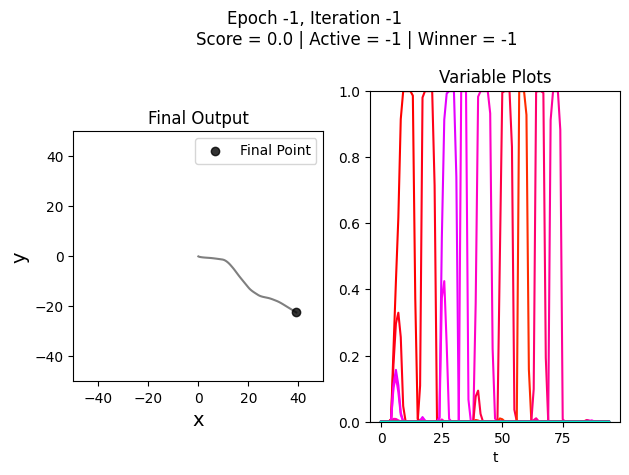

1180.0
[0.786 0.    0.    0.    0.    0.    0.    0.    0.    0.283 0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.221 0.    0.999 0.872 0.885 0.545 0.564 0.949 0.898 0.982]
0.0


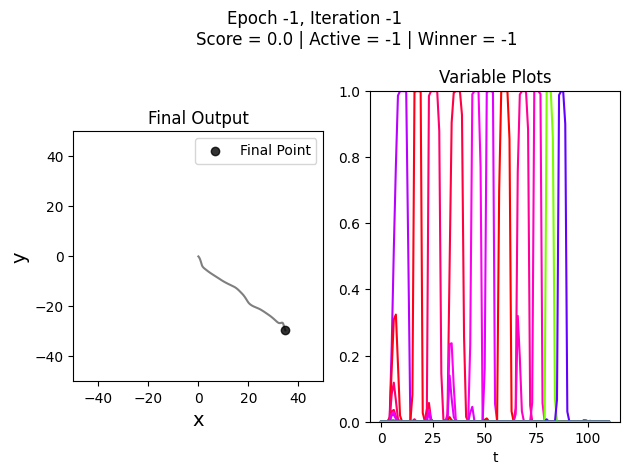

1400.0
[0.    0.    0.213 0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.236 0.    0.    0.    0.    0.    0.    0.    0.374
 0.847 0.772 0.92  0.901 0.551 0.577 0.906 0.936 0.    0.    0.    0.   ]
0.0


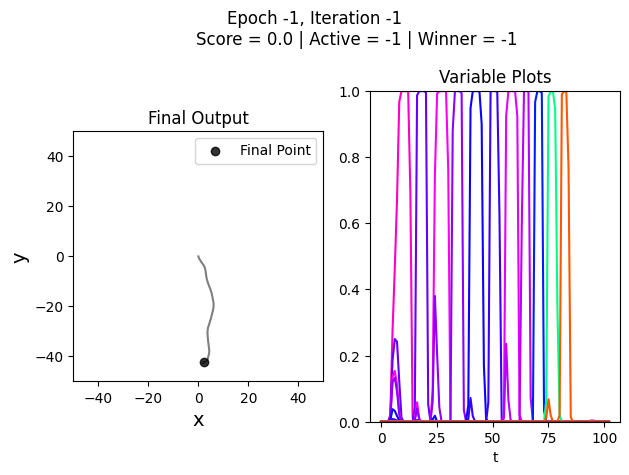

450.0
[0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
 0.    0.    0.    0.917 0.921 0.968 0.923 0.85  0.98  0.925 0.949 0.769
 0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.   ]
0.011


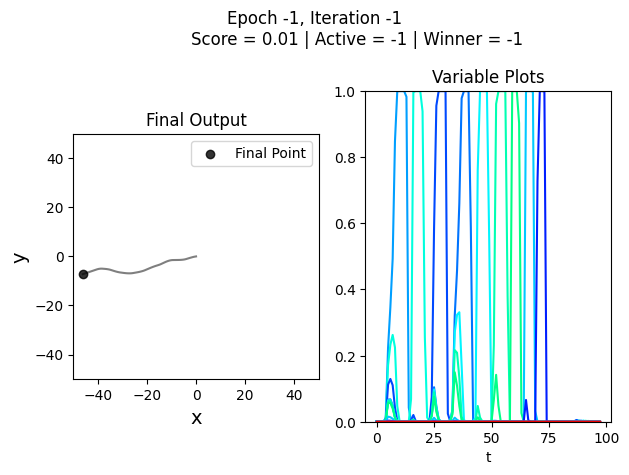

In [145]:
score = 0.0
while score < 0.01:
    # code_input = np.concatenate((np.linspace(1, min_activity_value+0.2, num_desired_high), np.zeros(crn.ring_layer.num_ring_units-num_desired_high)))
    # r = np.random.randint(0, crn.ring_layer.num_ring_units)
    # code_input = np.roll(code_input, r)
    code_input = bimodal_exponential_noise(num_low=noise_num_low, 
                                        num_high=noise_num_high, 
                                        noise_rate_low=noise_rate_low,
                                        noise_rate_high=noise_rate_high,
                                        shuffle=False,
                                        clip_01=True)
    roll_val = np.random.randint(0, crn.code_layer.num_code_units)
    code_input = np.roll(code_input, roll_val)
    code_output = np.where(code_input >= min_activity_value, code_input, 0.0)

    score = metric(code_output, min_activity_value=min_activity_value, penalty_rate=-0.01)

    # print(code_output)

    # determine output of code layer (input into ring layer)
    ring_input = (crn.code_layer.weights_to_ring_from_code @ code_output).squeeze()
    print(np.round(ring_input, 3))
    print(np.round(score, 3))

    # determine activity of duration layer
    # TODO: right now, this is just a constant
    dur_output = crn.duration_layer.activate(durs)

    # integrate ring layer model over time
    v_series, z_series, u_series, I_prime_series = crn.ring_layer.activate(ring_input, dur_output, t_max=tmax, t_steps=max_tsteps)

    # limit t_steps to end of integration
    t_steps = z_series.shape[1]

    ## get points for peak of each effector's activity
    # # get peaks of z spikes
    # max_times = np.argmax(z_series, axis=1).flatten()
    # peak_vals = z_series[np.arange(crn.ring_layer.num_ring_units),max_times]
    # active_idxs = np.argwhere(peak_vals > 0.4).flatten()
    # act_mdpt_times = max_times[active_idxs]
    # mdpts = np.vstack((x_series[act_mdpt_times], y_series[act_mdpt_times])).T
    midpts = np.empty(0) 

    # apply model results to the drawing system
    x_series, y_series = crn.ring_layer.create_drawing(z_series, t_steps)

    crn.plot_results(x_series, y_series, midpts, ring_input, v=[], u=[], z=z_series, I_prime=[], folder_name=crn.folder_name, epoch=-1, iteration=-1, active_idx=-1, winner_idx=-1, score=score)
